cpu will be used for training the PaiNN model


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 278031538176 bytes.

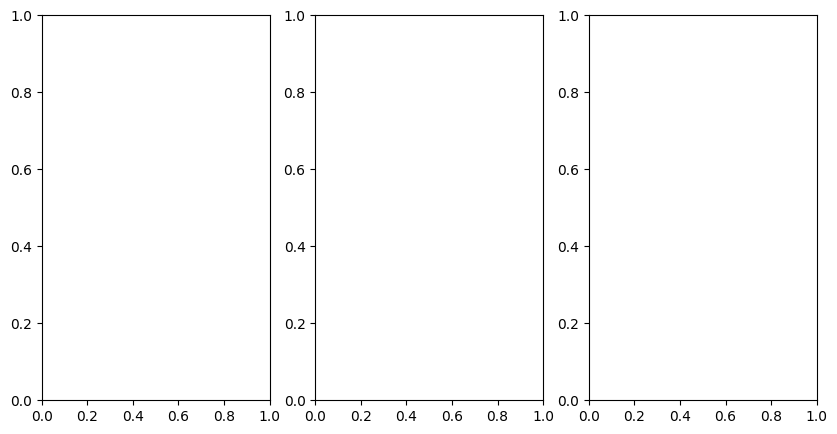

In [1]:
import torch
import torch.nn as nn
import numpy
from Dataloader import DataLoaderQM9
from Model import PaiNN
from Training import Trainer
from Training import mse


def training():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"{device} will be used for training the PaiNN model")
        model = PaiNN(r_cut=5, 
                device=device
                ).to(device)

        train_set = DataLoaderQM9(r_cut=5)
        optimizer = torch.optim.Adam(params=model.parameters(), lr = 5e-4, weight_decay = 0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience = 5)
        trainer = Trainer(
            model=model,
            loss=mse,
            target=2,
            optimizer=optimizer,
            data_loader=train_set,
            scheduler=scheduler,
            device=device
        )
        trainer._train(num_epoch = 3, early_stopping = 2)
        trainer.plot_data()

if __name__=="__main__":
    training()